# Прогнозирование с использованием модели ARIMA

## Загрузка данных

In [1]:
import pandas as pd # Работа с табличными данными и рядами
import numpy as np # Работа с массивами
import statsmodels.api as sm # Анализ и построение моделей авторегрессии
from statsmodels.tsa.ar_model import AutoReg, ar_select_order # для AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # для визуализации АКФ и ЧАКФ
from statsmodels.tsa.statespace.tools import diff #для дифференцирования ряда
from statsmodels.tsa.api import SARIMAX #для моделей SARIMAX

import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация

# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

Для обработки табличных данных в Python используется пакет pandas. С тем, как выполнять базовые операции с таблицами и рядами pandas, можно познакомиться по блокнотам в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/pandas).

In [2]:
catalog = pd.read_excel('catalog.xlsx', # файл с данными
                       index_col='date')  # столбец 'date' нужно использовать как индекс

catalog = catalog.asfreq('MS') # Уточнили частоту наблюдений - ежемесячно, для индекса используется 1й день месяца.

catalog

,men,women,jewel,mail,page,phone,printadv,service
date,,,,,,,,
1989-01-01,11357.92,16578.93,10776.38,7978,73,34,22294.48,20
1989-02-01,10605.95,18236.13,10821.97,8290,88,29,27426.47,20
1989-03-01,16998.57,43393.55,22845.79,8029,65,24,27978.66,26
1989-04-01,6563.75,30908.49,11102.62,7752,85,20,28949.65,22
1989-05-01,6607.69,28701.58,16066.57,8685,74,17,22642.27,21
...,...,...,...,...,...,...,...,...
1998-08-01,30208.17,58660.76,24377.91,11808,85,44,26668.16,45
1998-09-01,24467.94,57791.14,16044.00,12781,83,49,29911.68,54
1998-10-01,23602.00,56329.40,15974.66,11690,95,43,27872.97,55


Используя встроенные в pandas визуализации, посмотрим на данные. С визуализацией табличных данных в python можно познакомиться в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/EDA)

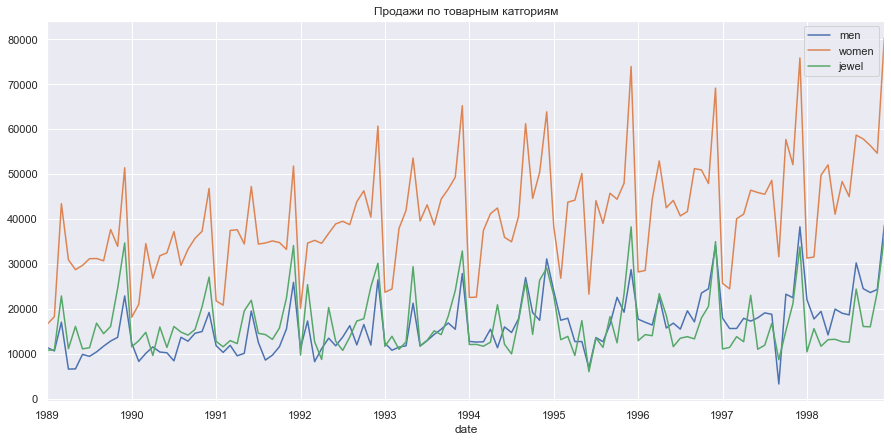

In [3]:
catalog.iloc[:, :3].plot(figsize=(15,7), title='Продажи по товарным катгориям');

На графике виден тренд и сезонность. Тип сезонности - мультипликативный.

## Моделирование

Выберем для анализа только одну товарную категорию - продажи женской одежды


In [4]:
women = catalog[['women', 'mail', 'page', 'phone', 'printadv', 'service']]

Для проверки моделей разделим ряд на два подмножества, используя в качестве тестового множества последний год, а остальные данные - в качестве обучающего множества.

In [5]:
women_train = women[:'1997-12-01'].copy() # Обучающее множество
women_test = women['1998-01-01':].copy() # Тестовое множество

### Разведочный анализ

Для исследования зависимостей в данных можно использовать диаграммы рассеяния. Для анализа зависимостей сразу для всех факторов удобно использовать матричную диаграмму рассеяния.

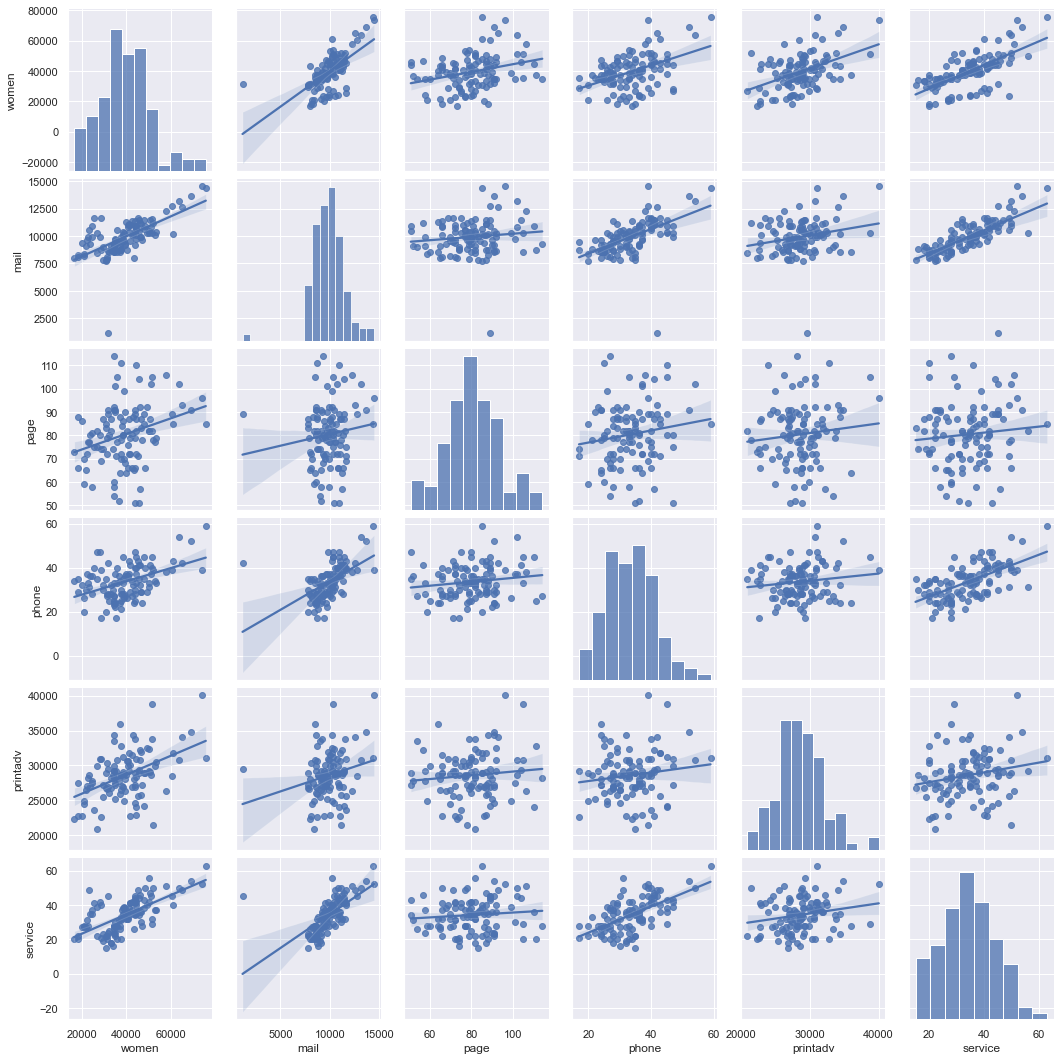

In [6]:
sns.pairplot(women_train, kind='reg');

Количественную оценку тесноты и направления зависимости можно получить при помощи коэффициентов корреляции.

In [7]:
women_corr = women_train.corr().round(2)
women_corr

,women,mail,page,phone,printadv,service
women,1.00,0.65,0.29,0.45,0.46,0.66
mail,0.65,1.00,0.12,0.54,0.22,0.64
page,0.29,0.12,1.00,0.15,0.11,0.10
phone,0.45,0.54,0.15,1.00,0.14,0.60
printadv,0.46,0.22,0.11,0.14,1.00,0.20
service,0.66,0.64,0.10,0.60,0.20,1.00


Визуализация матрицы корреляций

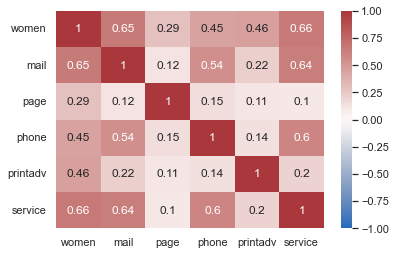

In [8]:
colormap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(women_corr, cmap=colormap, annot=True, vmin=-1, vmax=1);

Наиболее коррелированные с продажами факторы - mail и service.

### Модель авторегрессии

Для начала рассмотрим модель авторегрессии.
https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html

Модель имеет вид:

$$ y_t = \delta + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \varepsilon_t $$

Авторегрессия позволяет учитывать:  
 - тренд (`c` - константа, `ct` - константа и временной период, `t` - временной период);  
 - сезонные индексы (`seasonal=True`);  
 - внешние предикторы (`exog`)
 
 Полная спецификация модели:
 
 $$ y_t = \delta_0  + \delta_1 t + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + 
     \sum_{i=1}^{s-1} \gamma_i d_i + \sum_{j=1}^{m}\kappa_jx_{t,j} + \varepsilon_t $$

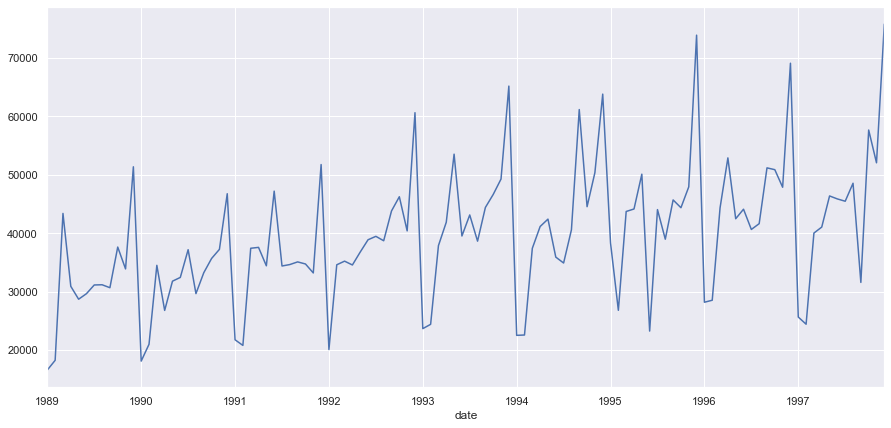

In [9]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot();

Ряд нестационарный, содержит тренд и сезонный компонент. Применим к нему сезонную разность.

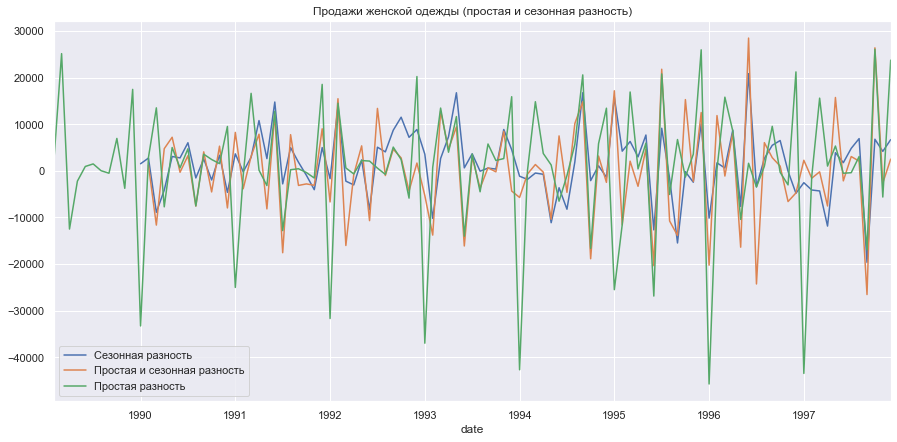

In [10]:
women_sd1 = diff(women_train['women'], k_diff=0, k_seasonal_diff=1, seasonal_periods=12) # только сезонная разность
women_d1sd1 = diff(women_train['women'], k_diff=1, k_seasonal_diff=1, seasonal_periods=12) # простая и сезонная разность
women_d1 = diff(women_train['women'], k_diff=1, k_seasonal_diff=0, seasonal_periods=12) # простая разность

plt.subplots(figsize=(15, 7))
women_sd1.plot(label='Сезонная разность')
women_d1sd1.plot(label='Простая и сезонная разность')
women_d1.plot(label='Простая разность')
plt.title('Продажи женской одежды (простая и сезонная разность)')
plt.legend();


Все виды разности устраняют тренд. Но простой разности недостаточно, т.к. ряд явно содержит сезонный компонент. Между сезонной разностью и сезонной+простой разностью разницы практически нет, выбираем более простую сезонную разность.

Для моделирования ряда понадобится либо включать как минимум 12 лагов, либо использовать сезонную разность, либо использовать сезонные индексы.

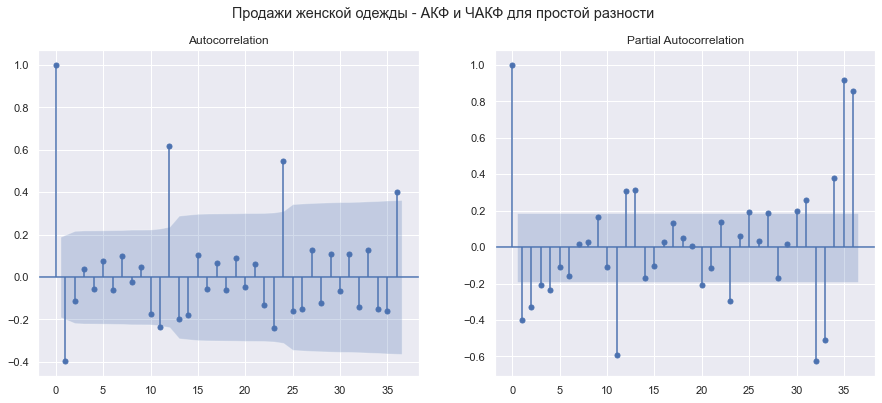

In [11]:
# Визуализация АКФ и ЧАКФ для простой разности
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig = plot_acf(women_d1, lags=36, ax=axes[0])
fig = plot_pacf(women_d1, lags=36, ax=axes[1])

plt.suptitle('Продажи женской одежды - АКФ и ЧАКФ для простой разности');

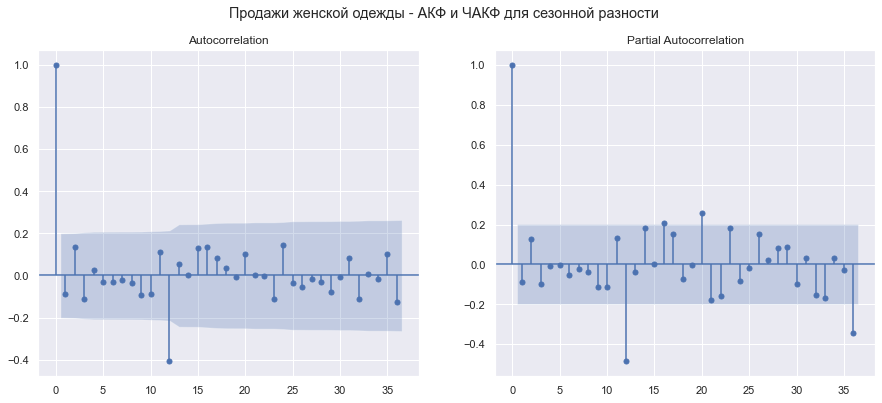

In [12]:
# Визуализация АКФ и ЧАКФ для сезонной разности
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig = plot_acf(women_sd1, lags=36, ax=axes[0])
fig = plot_pacf(women_sd1, lags=36, ax=axes[1])

plt.suptitle('Продажи женской одежды - АКФ и ЧАКФ для сезонной разности');

Построим модель авторегрессии с 12 лагами

In [13]:
women_sel_ar12 = ar_select_order(women_train['women'], maxlag=13, glob=True, old_names=False) #Автовыбор порядка модели
women_sel_ar12.ar_lags

array([12])

В результате оптимизации оказалось, что необходимо включать только 12-й лаг.

In [14]:
women_m_ar12 = women_sel_ar12.model.fit()
women_m_ar12.summary()

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  women   No. Observations:                  108
Model:             Restr. AutoReg(12)   Log Likelihood                -982.483
Method:               Conditional MLE   S.D. of innovations           6736.261
Date:                Thu, 17 Mar 2022   AIC                             17.693
Time:                        09:27:51   BIC                             17.773
Sample:                    01-01-1990   HQIC                            17.725
                         - 12-01-1997                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7907.0457   2492.616      3.172      0.002    3021.609    1.28e+04
women.L12      0.8370      0.062     13.570      0.000       0.716       0.958
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0149           -0.0000j            1.0149           -0.5000
AR.2            -0.8790           -0.5075j            1.0149           -0.4167
AR.3            -0.8790           +0.5075j            1.0149            0.4167
AR.4            -0.5075           -0.8790j            1.0149           -0.3333
AR.5            -0.5075           +0.8790j            1.0149            0.3333
AR.6            -0.0000           -1.0149j            1.0149           -0.2500
AR.7            -0.0000           +1.0149j            1.0149            0.2500
AR.8             0.5075           -0.8790j            1.0149           -0.1667
AR.9             0.5075           +0.8790j            1.0149            0.1667
AR.10            1.0149           -0.0000j            1.0149           -0.0000
AR.11            0.8790           -0.5075j            1.0149           -0.0833
AR.12            0.8790           +0.5075j            1.0149            0.0833
------------------------------------------------------------------------------
"""

Визуализация прогноза

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


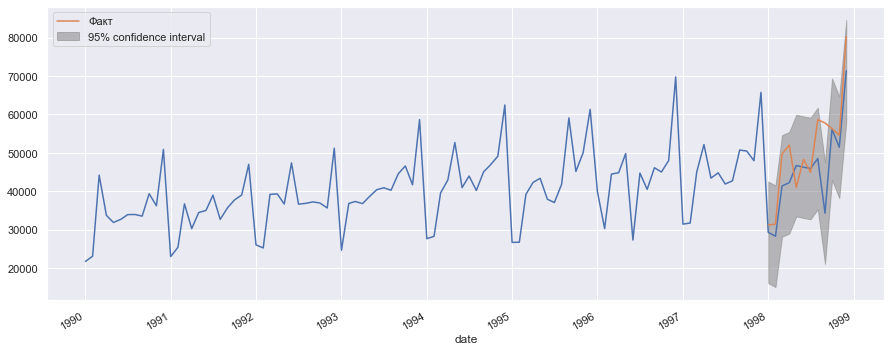

In [15]:
#plt.subplots(figsize=(15,6))
women_m_ar12.plot_predict(end='1998-12-01', figsize=(15,6))
women_test['women'].plot(label='Факт')
plt.legend();

Рассчитаем показатели ошибки прогноза

In [16]:
# Подготовка функций для расчета показателей ошибки
from statsmodels.tools.eval_measures import rmse, bias, meanabs

mape = lambda actuals, forecast : ((actuals - forecast).abs() / actuals).mean()

def metrics(model, actuals, forecast):
    return pd.DataFrame({'model' : model, 
                         'mape' : mape(actuals, forecast),
                         'rmse' : rmse(actuals, forecast),
                         'bias' : bias(actuals, forecast)
                        }, index = [1])

In [17]:
women_f_ar12 = women_m_ar12.predict(start='1998-01-01', end='1998-12-01')
women_f_ar12

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


1998-01-01    29373.798594
1998-02-01    28347.997510
1998-03-01    41411.941498
1998-04-01    42270.076274
1998-05-01    46731.404524
1998-06-01    46302.529644
1998-07-01    45973.583281
1998-08-01    48552.950974
1998-09-01    34338.234576
1998-10-01    56179.382534
1998-11-01    51482.323758
1998-12-01    71366.273916
Freq: MS, dtype: float64

In [18]:
women_metrics = metrics('Авторегрессия 12 лагов', women_test['women'], women_f_ar12)
women_metrics

,model,mape,rmse,bias
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076


### Авторегрессия + сезонные фиктивные переменные

In [19]:
women_sel_ar12s = ar_select_order(women_train['women'], maxlag=13, glob=True, seasonal=True, old_names=False) #Автовыбор порядка модели
women_sel_ar12s.ar_lags

array([ 2,  4, 11])

При включении сезонных фиктивных переменных значимыми оказались другие лаги авторегрессии.

In [20]:
women_m_ar12s = women_sel_ar12s.model.fit()
women_m_ar12s.summary()

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               AutoReg Model Results                                
====================================================================================
Dep. Variable:                        women   No. Observations:                  108
Model:             Restr. Seas. AutoReg(11)   Log Likelihood                -967.456
Method:                     Conditional MLE   S.D. of innovations           5191.807
Date:                      Thu, 17 Mar 2022   AIC                             17.440
Time:                              09:27:54   BIC                             17.864
Sample:                          12-01-1989   HQIC                            17.611
                               - 12-01-1997                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4682.0156   4428.837     -1.057      0.290   -1.34e+04    3998.346
s(2,12)    -7989.4038   3270.665     -2.443      0.015   -1.44e+04   -1579.019
s(3,12)     1.347e+04   3371.051      3.995      0.000    6860.492    2.01e+04
s(4,12)     9166.8685   3850.705      2.381      0.017    1619.626    1.67e+04
s(5,12)     1.949e+04   3484.630      5.594      0.000    1.27e+04    2.63e+04
s(6,12)     1.465e+04   3537.358      4.141      0.000    7714.476    2.16e+04
s(7,12)     1.239e+04   2899.345      4.272      0.000    6703.880    1.81e+04
s(8,12)     9810.5767   3177.344      3.088      0.002    3583.098     1.6e+04
s(9,12)      1.34e+04   3085.418      4.343      0.000    7351.564    1.94e+04
s(10,12)    1.652e+04   3180.637      5.195      0.000    1.03e+04    2.28e+04
s(11,12)    8974.6348   4191.502      2.141      0.032     759.443    1.72e+04
s(12,12)    3.854e+04   2585.941     14.902      0.000    3.35e+04    4.36e+04
women.L2       0.2207      0.091      2.422      0.015       0.042       0.399
women.L4       0.2772      0.098      2.819      0.005       0.084       0.470
women.L11      0.3298      0.089      3.718      0.000       0.156       0.504
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0404           -0.2425j            1.0683           -0.4636
AR.2            -1.0404           +0.2425j            1.0683            0.4636
AR.3            -0.7611           -0.8602j            1.1486           -0.3653
AR.4            -0.7611           +0.8602j            1.1486            0.3653
AR.5             1.0296           -0.0000j            1.0296           -0.0000
AR.6             0.9783           -0.5641j            1.1292           -0.0832
AR.7             0.9783           +0.5641j            1.1292            0.0832
AR.8             0.4505           -1.0348j            1.1286           -0.1847
AR.9             0.4505           +1.0348j            1.1286            0.1847
AR.10           -0.1420           -1.0882j            1.0975           -0.2706
AR.11           -0.1420           +1.0882j            1.0975            0.2706
------------------------------------------------------------------------------
"""

Визуализация прогноза

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


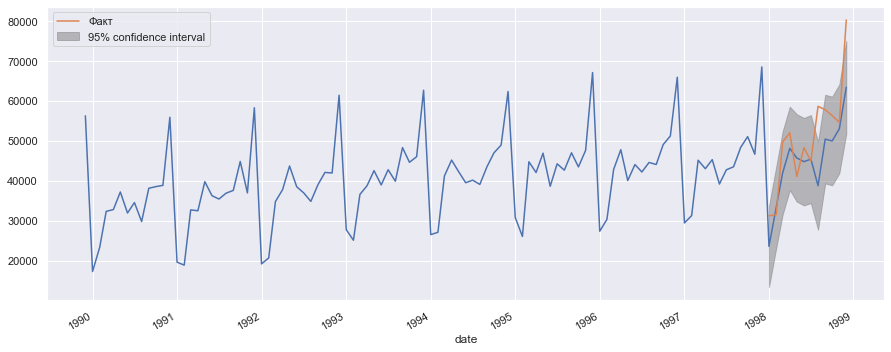

In [21]:
#plt.subplots(figsize=(15,6))
women_m_ar12s.plot_predict(end='1998-12-01', figsize=(15,6))
women_test['women'].plot(label='Факт')
plt.legend();

In [22]:
women_f_ar12s = women_m_ar12s.predict(start='1998-01-01', end='1998-12-01')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [23]:
women_metrics = women_metrics.append(
    metrics('Авторегрессия 12 + сезнность', women_test['women'], women_f_ar12s))
women_metrics

,model,mape,rmse,bias
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076
1,Авторегрессия 12 + сезнность,0.128889,8884.629064,5659.040242


### Авторегрессия + внешние факторы

In [24]:
women_train.head(3)

,women,mail,page,phone,printadv,service
date,,,,,,
1989-01-01,16578.93,7978,73,34,22294.48,20
1989-02-01,18236.13,8290,88,29,27426.47,20
1989-03-01,43393.55,8029,65,24,27978.66,26


In [25]:
women_sel_ar12exog = ar_select_order(women_train['women'], 
                                     exog=women_train.loc[:, 'mail':'service'],
                                     maxlag=13, glob=True, seasonal=True, old_names=False) #Автовыбор порядка модели
women_sel_ar12exog.ar_lags

array([ 6,  9, 11])

In [26]:
women_m_ar12exog = women_sel_ar12exog.model.fit()
women_m_ar12exog.summary()

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                AutoReg Model Results                                 
======================================================================================
Dep. Variable:                          women   No. Observations:                  108
Model:             Restr. Seas. AutoReg-X(11)   Log Likelihood                -928.885
Method:                       Conditional MLE   S.D. of innovations           3488.407
Date:                        Thu, 17 Mar 2022   AIC                             16.747
Time:                                09:27:58   BIC                             17.305
Sample:                            12-01-1989   HQIC                            16.973
                                 - 12-01-1997                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.724e+04   5365.944     -3.212      0.001   -2.78e+04   -6721.020
s(2,12)    -2793.4090   2079.205     -1.343      0.179   -6868.577    1281.758
s(3,12)     9797.2557   2128.385      4.603      0.000    5625.698     1.4e+04
s(4,12)     1.162e+04   2186.107      5.317      0.000    7337.957    1.59e+04
s(5,12)     1.156e+04   2071.666      5.578      0.000    7495.721    1.56e+04
s(6,12)     1.345e+04   2578.974      5.216      0.000    8398.260    1.85e+04
s(7,12)     8121.2677   2219.326      3.659      0.000    3771.468    1.25e+04
s(8,12)     7963.1720   2372.472      3.356      0.001    3313.211    1.26e+04
s(9,12)     2.072e+04   2493.020      8.311      0.000    1.58e+04    2.56e+04
s(10,12)      1.1e+04   2656.989      4.139      0.000    5790.972    1.62e+04
s(11,12)    8347.0887   3386.621      2.465      0.014    1709.433     1.5e+04
s(12,12)    2.132e+04   2264.193      9.416      0.000    1.69e+04    2.58e+04
women.L6      -0.1718      0.073     -2.366      0.018      -0.314      -0.030
women.L9      -0.2400      0.068     -3.546      0.000      -0.373      -0.107
women.L11      0.1771      0.068      2.593      0.010       0.043       0.311
mail           2.1295      0.334      6.367      0.000       1.474       2.785
page          -8.1727     34.378     -0.238      0.812     -75.553      59.208
phone         75.0745     67.302      1.115      0.265     -56.834     206.983
printadv       0.6168      0.122      5.068      0.000       0.378       0.855
service      437.3444     62.439      7.004      0.000     314.966     559.723
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0039           -0.5227j            1.1318           -0.0764
AR.2             1.0039           +0.5227j            1.1318            0.0764
AR.3             1.4042           -0.0000j            1.4042           -0.0000
AR.4             0.5081           -1.0194j            1.1390           -0.1764
AR.5             0.5081           +1.0194j            1.1390            0.1764
AR.6            -0.1448           -1.0646j            1.0744           -0.2715
AR.7            -0.1448           +1.0646j            1.0744            0.2715
AR.8            -0.8328           -0.7689j            1.1335           -0.3813
AR.9            -0.8328           +0.7689j            1.1335            0.3813
AR.10           -1.2365           -0.3206j            1.2774           -0.4596
AR.11           -1.2365           +0.3206j            1.2774            0.4596
------------------------------------------------------------------------------
"""

Визуализация прогноза

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


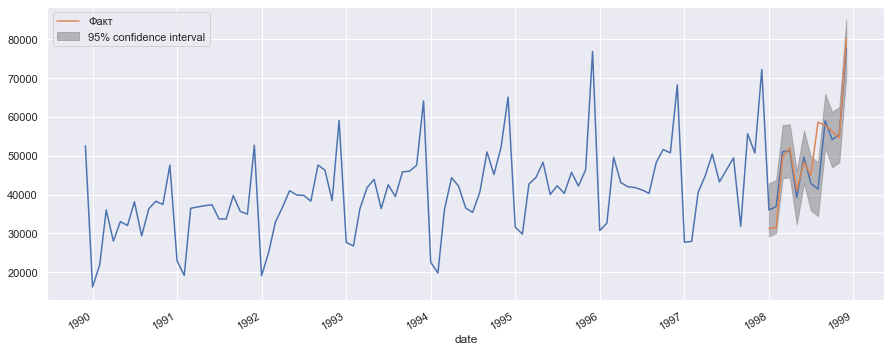

In [27]:
women_m_ar12exog.plot_predict(exog_oos=women_test.loc[:, 'mail':'service'],
                              end='1998-12-01', figsize=(15,6))
women_test['women'].plot(label='Факт')
plt.legend();

In [28]:
women_f_ar12exog = women_m_ar12exog.predict(exog_oos=women_test.loc[:, 'mail':'service'],
                                            start='1998-01-01', end='1998-12-01')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [29]:
women_metrics = women_metrics.append(
    metrics('Авторегрессия 12 + факторы', women_test['women'], women_f_ar12exog))
women_metrics

,model,mape,rmse,bias
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076
1,Авторегрессия 12 + сезнность,0.128889,8884.629064,5659.040242
1,Авторегрессия 12 + факторы,0.073787,5597.406655,988.762355


### SARIMAX

SARIMAX - метод для оценки моделей вида:

 - простая ARMA(1,1) модель:


- простая ARIMA(1,1,1) модель:
$$ \Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \varepsilon_{t-1} + \varepsilon_t $$

- сезонная ARIMA(2,1,0)(1,1,0) модель:

$$ (1-\phi_1 L - \phi_2 L^2) (1-\tilde{\phi_1}L^{12})\Delta \Delta_{12} y_t = c + \varepsilon_t $$

$L$ в формуле обозначает оператор сдвига. Последняя запись эквивалентна:

$$ (1 - \phi_1 L - \phi_2 L^2 - \tilde{\phi_1} L^{12} + \phi_1 \tilde{\phi_1} L^{13} + \phi_2 \tilde{\phi_1} L^{14}) y_t = c + \varepsilon_t $$

и

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \tilde{\phi_1} y_{t-12} - \phi_1 \tilde{\phi_1} y_{t-13} - \phi_2 \tilde{\phi_1} y_{t-14} + \varepsilon_t $$

https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

Для спецификации модели необходимо задать порядки для компонентов AR и MA, порядок разности, а также аналогичные порядки для сезонных компонентов. Значения следуют в таком порядке: (порядок AR, порядок разности, порядок MA). Сезонные компоненты указываются в той же последовательности.

Для определения порядка компонентов модели необходимо использовать графики АКФ и ЧАКФ.

#### Простая ARIMA модель

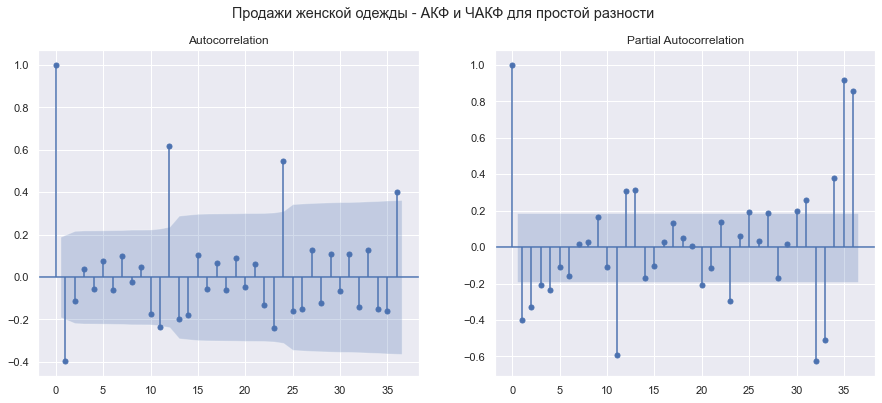

In [30]:
# Визуализация АКФ и ЧАКФ для простой разности
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig = plot_acf(women_d1, lags=36, ax=axes[0])
fig = plot_pacf(women_d1, lags=36, ax=axes[1])

plt.suptitle('Продажи женской одежды - АКФ и ЧАКФ для простой разности');

Графики напоминают процесс MA(1), однако присутствует сезонный компонент, поэтому нужно будет еще включать компонент AR(12). Эти графики построены на основе простой разности, поэтому модель будет также включать и простую разность порядка 1.
Итого, спецификация модели - ARIMA(12,1,1).

При включении всех 12 AR-лагов по спецификации (12,1,1) все AR-коэффициенты, кроме 12-го получились незначимыми, поэтому в этом примере указано, что включать надо только 12-й лаг.

Процедура оптимизации параметров может не сходиться. Про возможные варианты действий можно почитать здесь:
https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

В этом примере было увеличено число итераций поиска оптимальных параметров (`maxiter=200`), также можно попробовать переключить метод оптимизации на метод Нелдера-Мида (`.fit(maxiter=200, method='nm')`)

In [31]:
women_m_arima = SARIMAX(women_train['women'], order=((0,0,0,0,0,0,0,0,0,0,0,1), 1, 1)).fit(maxiter=200)
women_m_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                   women   No. Observations:                  108
Model:             SARIMAX([12], 1, 1)   Log Likelihood               -1120.399
Date:                 Thu, 17 Mar 2022   AIC                           2246.798
Time:                         09:27:59   BIC                           2254.816
Sample:                     01-01-1989   HQIC                          2250.048
                          - 12-01-1997                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L12         0.6986      0.063     11.025      0.000       0.574       0.823
ma.L1         -0.9431      0.037    -25.644      0.000      -1.015      -0.871
sigma2      7.937e+07   1.28e-10   6.18e+17      0.000    7.94e+07    7.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               125.74
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.08
Prob(H) (two-sided):                  0.51   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+32. Standard errors may be unstable.
"""

In [32]:
women_f_arima = women_m_arima.predict(start='1998-01-01', end='1998-12-01')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


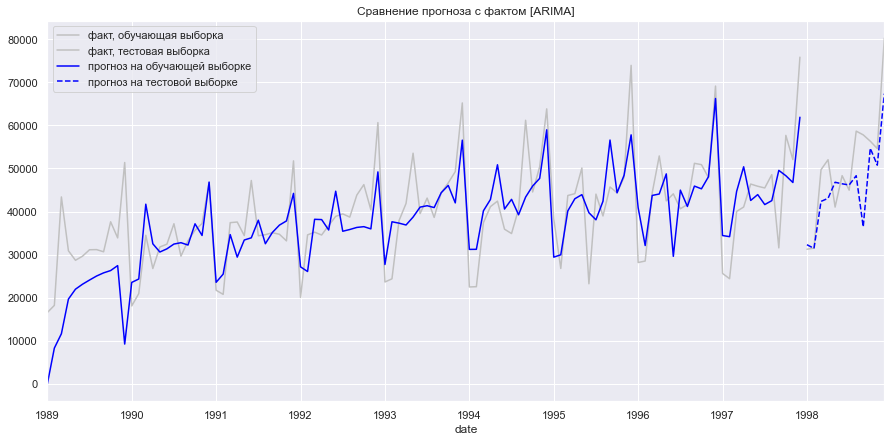

In [33]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_arima.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_arima.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [ARIMA]')
plt.legend();

In [34]:
women_metrics = women_metrics.append(
    metrics('ARIMA', women_test['women'], women_f_arima))
women_metrics

,model,mape,rmse,bias
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076
1,Авторегрессия 12 + сезнность,0.128889,8884.629064,5659.040242
1,Авторегрессия 12 + факторы,0.073787,5597.406655,988.762355
1,ARIMA,0.113936,8752.081607,5024.790722


#### Сезонная ARIMA модель


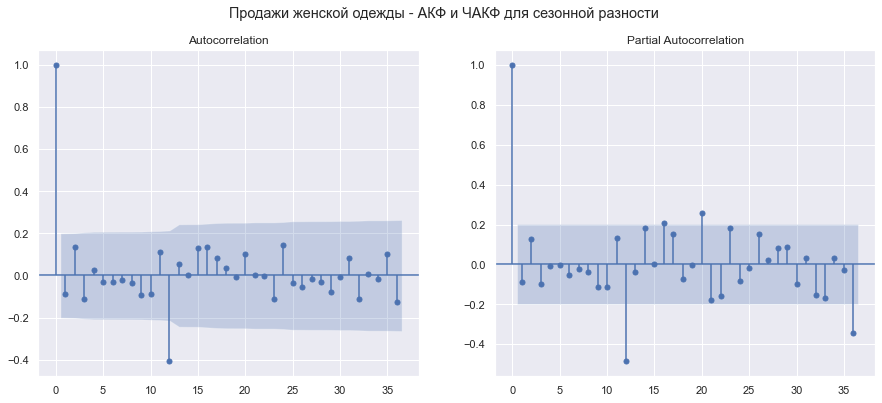

In [35]:
# Визуализация АКФ и ЧАКФ для сезонной разности
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig = plot_acf(women_sd1, lags=36, ax=axes[0])
fig = plot_pacf(women_sd1, lags=36, ax=axes[1])

plt.suptitle('Продажи женской одежды - АКФ и ЧАКФ для сезонной разности');

Графики АКФ и ЧАКФ для сезонной разности позволяют предположить, что ряд может быть описан моделью SARIMA(0,0,0)(0,1,1). В реализации statsmodels дополнительно надо указать 4-й параметр для сезонного компонента - длина сезонного цикла.

In [36]:
women_m_sarima = SARIMAX(women_train['women'], order=(0,0,0), seasonal_order=(0,1,1,12)).fit(maxiter=200)
women_m_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      women   No. Observations:                  108
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -986.891
Date:                    Thu, 17 Mar 2022   AIC                           1977.783
Time:                            09:28:00   BIC                           1982.911
Sample:                        01-01-1989   HQIC                          1979.856
                             - 12-01-1997                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0893      0.077     -1.157      0.247      -0.240       0.062
sigma2      5.544e+07   1.61e-10   3.44e+17      0.000    5.54e+07    5.54e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 3.66
Prob(Q):                              0.43   Prob(JB):                         0.16
Heteroskedasticity (H):               1.99   Skew:                            -0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+33. Standard errors may be unstable.
"""

In [37]:
women_f_sarima = women_m_sarima.predict(start='1998-01-01', end='1998-12-01')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


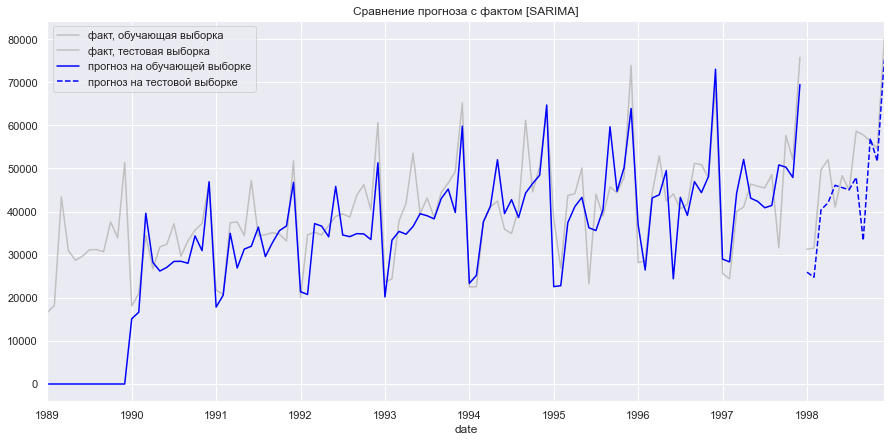

In [38]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_sarima.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_sarima.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [SARIMA]')
plt.legend();

In [39]:
women_metrics = women_metrics.append(
    metrics('SARIMA', women_test['women'], women_f_sarima))
women_metrics

,model,mape,rmse,bias
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076
1,Авторегрессия 12 + сезнность,0.128889,8884.629064,5659.040242
1,Авторегрессия 12 + факторы,0.073787,5597.406655,988.762355
1,ARIMA,0.113936,8752.081607,5024.790722
1,SARIMA,0.140103,9321.661885,5953.155229


### Сезонная ARIMA-модель с внешними факторами

In [40]:
women_m_sarimax = SARIMAX(women_train['women'], exog=women_train.loc[:, ['mail', 'printadv', 'service']], 
                          order=(0,0,0), seasonal_order=(0,1,1,12)).fit(maxiter=200)
women_m_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      women   No. Observations:                  108
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -951.226
Date:                    Thu, 17 Mar 2022   AIC                           1912.452
Time:                            09:28:00   BIC                           1925.273
Sample:                        01-01-1989   HQIC                          1917.635
                             - 12-01-1997                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mail           1.8122      0.661      2.744      0.006       0.518       3.107
printadv       0.4129      0.220      1.876      0.061      -0.018       0.844
service      331.9884     83.110      3.995      0.000     169.095     494.882
ma.S.L12      -0.5976      0.105     -5.697      0.000      -0.803      -0.392
sigma2      3.204e+07      0.001   2.68e+10      0.000     3.2e+07     3.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               121.64
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+26. Standard errors may be unstable.
"""

In [41]:
women_f_sarimax = women_m_sarimax.predict(exog=women_test.loc[:, ['mail', 'printadv', 'service']],
                                          start='1998-01-01', end='1998-12-01')

W:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


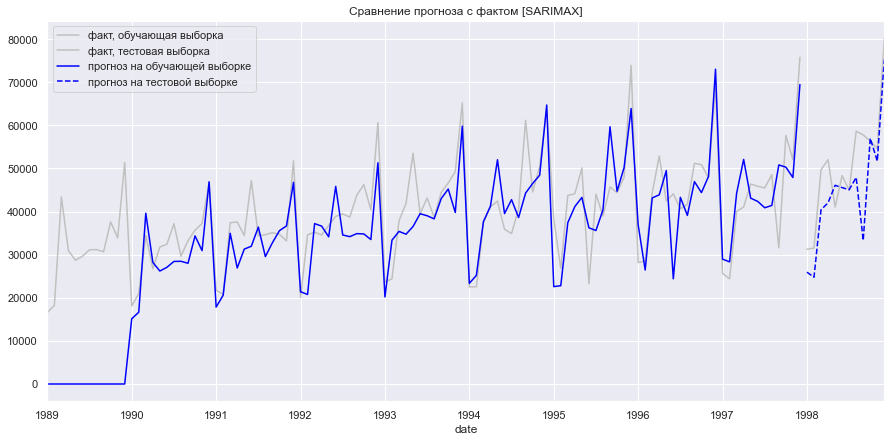

In [42]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_sarima.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_sarima.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [SARIMAX]')
plt.legend();

In [43]:
women_metrics = women_metrics.append(
    metrics('SARIMAX', women_test['women'], women_f_sarimax))
women_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,SARIMAX,0.048504,4028.902619,1489.460880
1,Авторегрессия 12 + факторы,0.073787,5597.406655,988.762355
1,ARIMA,0.113936,8752.081607,5024.790722
1,Авторегрессия 12 лагов,0.122299,8926.471882,5347.316076
1,Авторегрессия 12 + сезнность,0.128889,8884.629064,5659.040242
1,SARIMA,0.140103,9321.661885,5953.155229
